![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de una bicicleta durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://github.com/justmarkham/DAT8/blob/master/data/bikeshare.csv), [dicccionario de datos](https://www.kaggle.com/c/bike-sharing-demand/data).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)
# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)
# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour
# Visualización
bikes

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,19
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,20
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,21


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables hour y workingday, escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [4]:
# Celda 1.1
bikes.groupby('workingday').total.describe()

,count,mean,std,min,25%,50%,75%,max
workingday,,,,,,,,
0,3474.0,188.506621,173.724015,1.0,44.0,128.0,304.0,783.0
1,7412.0,193.011873,184.513659,1.0,41.0,151.0,277.0,977.0


La varibale ''workingday'' indica si el día del registro del alquiler de las biciletas era un día hábil o no. La variable es 0 si el día no era hábil y 1 si lo era. 

Podemos observar que hay 3470 registros en días no hábiles y 74120 en días hábiles. También es posible afirmar que en promedio hubo 189 alquileres en días no hábiles y 193 alquileres en día hábiles. 

Además, podemos ver que el máximo número de rentas en días no hábiles fue 738 y que el mínimo fue de 1, mientras que en días hábiles el máximo fue 977 y el mínimo 1 también. 

Es posible inferir que se alquilaron más bicicletas en días hábiles que en días no hábiles. 

Por último, podemos observar que en días no hábiles el 75% de alquileres fue de 304 o menos, mientras que en días hábiles este 75% fue 277 o menos. 

In [5]:
# Celda 1.2
bikes.groupby('hour').total.describe()

,count,mean,std,min,25%,50%,75%,max
hour,,,,,,,,
0,455.0,55.138462,43.620012,2.0,24.00,41.0,74.50,283.0
1,454.0,33.859031,34.112105,1.0,11.00,19.0,46.00,168.0
2,448.0,22.899554,26.110267,1.0,5.00,11.0,32.00,119.0
3,433.0,11.757506,12.666442,1.0,3.00,6.0,15.00,66.0
4,442.0,6.407240,4.217633,1.0,3.00,6.0,9.00,28.0
5,452.0,19.767699,12.784293,1.0,8.00,19.0,29.00,57.0
6,455.0,76.259341,54.745333,1.0,24.50,75.0,118.00,213.0
7,455.0,213.116484,159.207044,1.0,63.00,208.0,334.00,596.0
8,455.0,362.769231,231.723065,8.0,133.50,392.0,563.50,839.0


La variable ''hour'' representa la hora del día de los alquileres. la variable toma el valor de 0 para las 00:00:00 horas y 23 para las 23:00:00 horas. 

De esta variable podemos observar que la media del alquiler más alta se dio a las 17:00:00 horas, es decir a las 5 de la tarde. También es posible ver que apoximadamente a las 8 horas y a las 17 hay más alquileres. Probablemente porque son las horas donde las personas salen y vuelven a sus hogares. 

Por último, observamos también que a las 5 de la tarde, el 75% de alquileres corresponde a aproximadamente 608 o menos, siendo este el valor más alto del percentil 75 de todas las horas del día. 


### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica de las rentas promedio por hora cuando la variable "workingday" es igual a 0 e igual a 1, respectivamente. Analice y escriba sus hallazgos.

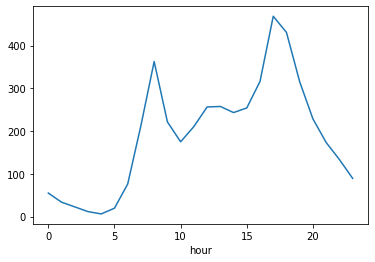

In [6]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

En esta gráfica, podemos ver las rentas promedio para cada valor de la variable "hour" que es practicamente una representación de la media de la información descriptiva que habíamos encontrado en el punto anterior. 

Podemos observar que la media del alquiler más alta se dio a las 17:00:00 horas, y que apoximadamente a las 8 horas y a las 17 hay más promedio de alquileres. Probablemente porque son las horas donde las personas salen y vuelven a sus hogares.

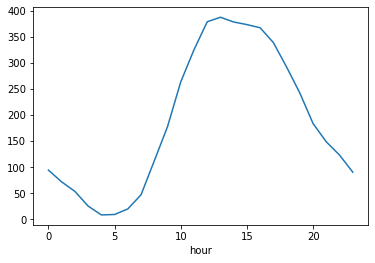

In [7]:
# Celda 2.2 - "workingday"=0 escriba su código y hallazgos
bikes_0=bikes[bikes['workingday']==0]
bikes_0.groupby('hour').total.mean().plot()

En esta gráfica podemos ver las rentas promedio para cada valor de la variable "hour" cuando la variable ''workingday'' es igual a 0, es decir cuando no es un día hábil. 

Podemos observar que el mayor promedio de alquileres en estos días se dio en horas de la tarde, aproximadamente desde las 12 hasta las 17 horas. 

El menor promedio de alquileres se encontró aproximadamente a las 4 y luego de las 5 empezó a incrementarse. A eso de las 17 horas el promedio de alquileres vuelve a disminiur a medida que van pasando las horas. 

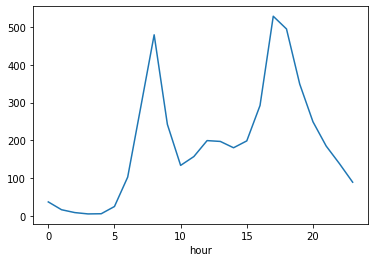

In [8]:
# Celda 2.3 - "workingday"=1 escriba su código y hallazgos 
bikes_1=bikes[bikes['workingday']==1]
bikes_1.groupby('hour').total.mean().plot()

En esta gráfica podemos ver las rentas promedio para cada valor de la variable "hour" cuando la variable ''workingday'' es igual a 1, es decir cuando es un día hábil.

Podemos observar que el mayor promedio de alquileres en estos días se dio en alrededor de las 8 y las 17 horas, muy parecido a la distribución que observamos de la gráfia de rentas promedio para cada valor de la variable "hour" para todos los días. Esto puede deberse a que hay más datos para este tipo de días. 

El menor promedio de alquileres se encontró aproximadamente a las 4 y luego de las 5 empezó a incrementarse hasta alrededor de las 8 donde volvió a bajar hasta las 10. Ahí, se mantuvo con pequeñas variaciones hasta las 15, donde empezó a subir y alcanzó su punto máximo alrededor de las 17 horas, para luego ir bajando a medida que pasaban las horas. 

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "hour" y "workingday" como las únicas variables predictoras. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

Score:  0.16059115011434866
Coeficientes:  [ 4.07248627 10.49206282]
Intercepto:  67.70595026191623
Error:  169.76793689821312


'\n Correlograma'

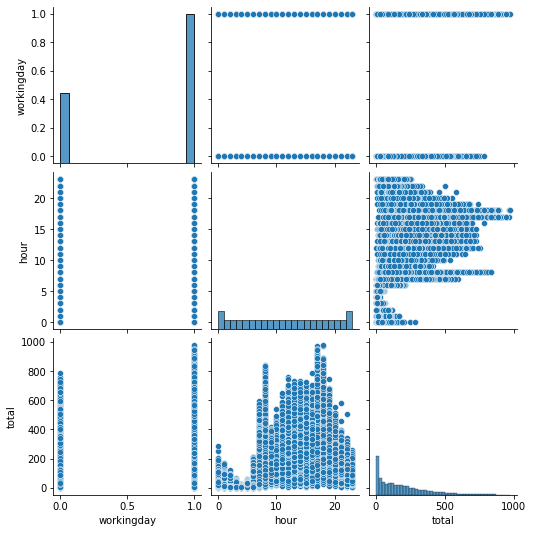

In [11]:
# Celda 3
X = bikes.loc[:,['workingday','hour']].reset_index(drop=True)
X_2 = bikes.loc[:,['workingday','hour', 'total']].reset_index(drop=True)
y = bikes['total']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

#Regresion lineal

#Regresion lineal
reg = LinearRegression().fit(X, y)
print('Score: ', reg.score(X, y))
print('Coeficientes: ', reg.coef_)
print('Intercepto: ', reg.intercept_)
predicciones=reg.predict(X_test)
print('Error: ', np.sqrt(mean_squared_error(predicciones, y_test)))

display('\n Correlograma')
sns.pairplot(X_2, kind="scatter")
plt.show()

Score:  0.16059115011434866 

Coeficientes:  [ 4.07248627 10.49206282]

Intercepto:  67.70595026191623

Error:  169.76793689821312

Podemos ver que los coeficientes de la regresión líneal son 4.07 y 10.49 en este caso. Por tando, podemos decir que hay una correlación positiva entre cada predictor y la variable dependiente. 

Sin embargo, es posible también observar que el score o el coeficiente de determinación de la predicción obtenido es bastante bajo y así mismo el error es alto. Por lo que podemos concluir que un modelo de regresión líneal no se adapta muy bien a este caso pues no se ajusta a los datos. 

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "workingday". El árbol debe tener al menos 6 nodos finales.

In [ ]:
# Celda 4


### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "hour" y "workingday" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de clasificación y compare desempeño con el modelo del punto 3.

In [ ]:
# Celda 5


## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir la cantidad de reacciones en redes sociales (popularidad) de la notica. Para más detalles puede visitar el sigueinte enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [52]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [59]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [60]:
y

0       1
1       0
2       0
3       0
4       0
       ..
5995    0
5996    1
5997    0
5998    0
5999    1
Name: Popular, Length: 6000, dtype: int64

In [ ]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [ ]:
# Celda 6


### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth = None\
-100 árboles de decisión donde max_depth = 2\
-100 regresiones logísticas

Evalúe los modelos utilizando las métricas de Accuracy y F1-Score.

In [ ]:
# Celda 7


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [ ]:
# Celda 8


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

In [ ]:
# Celda 9